<a href="https://colab.research.google.com/github/leoa4238/AI-Project/blob/main/template_150_Selective_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Selective Search 알고리즘**
Selective Search는 물체 탐지를 위한 **Region Proposal** 생성 알고리즘으로, 아래와 같은 3단계로 이루어집니다.

1. **초기 세그멘테이션 (Superpixel 생성)**:
   - 이미지를 작은 영역(Superpixel)으로 나눕니다.
   - 유사한 색상, 질감, 크기 등을 기준으로 초기 영역을 분할.  
2. **유사도 계산**:
   - Superpixel 간 유사도를 계산(색상, 크기, 질감 기반).
   - 유사도가 높은 Superpixel 쌍을 선택하여 병합.  
3. **Region 병합 반복**:
   - 유사도가 높은 영역들을 반복적으로 병합하여 점점 큰 Region Proposal을 생성.

---

### **코드 실행 순서**

1. **이미지 로드 및 준비**:
   - 이미지 파일(`example.jpg`)을 불러오고, 크기를 256x256으로 조정.
   - 이 과정은 `load_image` 함수에서 수행됩니다.  

2. **초기 Superpixel 분할**:
   - `segment_image` 함수를 사용해 SLIC (Simple Linear Iterative Clustering) 알고리즘으로 이미지를 Superpixel로 나눕니다.
   - 각 Superpixel은 초기 영역을 나타냅니다.
   - **시각화**: `visualize_initial_segmentation` 함수에서 Superpixel 분할 결과를 시각화.  

3. **Region Proposal 생성**:
   - `merge_regions` 함수로 Superpixel 간 유사도를 계산하고, 유사도가 높은 Superpixel을 반복적으로 병합.
   - 병합된 영역은 점점 큰 Region Proposal을 형성.
   - 유사도 계산은 **색상 거리 + 크기 차이**를 기준으로 수행.  

4. **Region Proposal 시각화**:
   - 병합된 Region Proposal을 `visualize_proposals` 함수로 시각화.
   - 빨간 사각형으로 Region Proposal을 표시.
---

### **결과**
1. **초기 분할**: 이미지를 작은 Superpixel로 나누어 경계선을 표시.
2. **병합 후 Proposal**: Superpixel을 병합한 Region Proposal을 빨간 사각형으로 표시.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

# 1. 이미지 로드 및 초기화
def load_image(image_path):
    from PIL import Image
    img = Image.open(image_path)
    img = img.resize((256, 256))  # 크기 조정
    return np.array(img)

# 2. 초기 세그멘테이션 (SLIC - Superpixel Segmentation)
def segment_image(image, n_segments=100):
    """
    이미지를 Superpixel로 나누기 위한 SLIC 알고리즘 적용
    """
    img_float = img_as_float(image)
    segments = slic(img_float, n_segments=n_segments, compactness=10, start_label=0)
    return segments

# 3. Superpixel 병합: 유사도를 계산하여 Superpixel 병합
def calculate_similarity(region1, region2):
    """
    두 영역 간의 유사도를 계산 (간단한 색상 기반 거리 사용)
    """
    color_dist = np.linalg.norm(region1['mean_color'] - region2['mean_color'])
    size_dist = abs(region1['size'] - region2['size']) / (region1['size'] + region2['size'])
    return color_dist + size_dist

def merge_regions(image, segments, num_merges=50):
    """
    Superpixel 간의 유사도를 계산하고 병합하여 Region Proposal 생성
    """
    height, width = image.shape[:2]
    region_props = {}  # 각 Region의 속성을 저장
    for region_label in np.unique(segments):
        mask = (segments == region_label)
        region_props[region_label] = {
            'size': mask.sum(),
            'mean_color': np.mean(image[mask], axis=0),
            'bbox': (
                mask.any(axis=0).argmax(),  # xmin
                mask.any(axis=1).argmax(),  # ymin
                mask.any(axis=0)[::-1].argmax(),  # xmax
                mask.any(axis=1)[::-1].argmax(),  # ymax
            )
        }

    for _ in range(num_merges):
        # 가능한 모든 영역 쌍에 대해 유사도 계산
        pairs = list(region_props.keys())
        best_pair, min_dist = None, float('inf')
        for i in range(len(pairs)):
            for j in range(i + 1, len(pairs)):
                region1 = region_props[pairs[i]]
                region2 = region_props[pairs[j]]
                dist = calculate_similarity(region1, region2)
                if dist < min_dist:
                    min_dist = dist
                    best_pair = (pairs[i], pairs[j])

        # 가장 유사한 두 영역 병합
        if best_pair:
            r1, r2 = best_pair
            region_props[r1]['size'] += region_props[r2]['size']
            region_props[r1]['mean_color'] = (
                region_props[r1]['mean_color'] * region_props[r1]['size'] +
                region_props[r2]['mean_color'] * region_props[r2]['size']
            ) / (region_props[r1]['size'] + region_props[r2]['size'])
            del region_props[r2]  # 병합된 영역 제거

    return region_props

# 4. 초기 분할 시각화
def visualize_initial_segmentation(image, segments):
    """
    초기 Superpixel 분할 결과를 시각화
    """
    segmented_image = mark_boundaries(image, segments)
    plt.figure(figsize=(6, 6))
    plt.imshow(segmented_image)
    plt.title("Initial Superpixel Segmentation")
    plt.axis("off")
    plt.show()

# 5. Region Proposal 시각화
def visualize_proposals(image, region_props):
    """
    Region Proposal을 시각화
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    for region in region_props.values():
        xmin, ymin, xmax, ymax = region['bbox']
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
    plt.title("Region Proposals after Merging")
    plt.axis("off")
    plt.show()

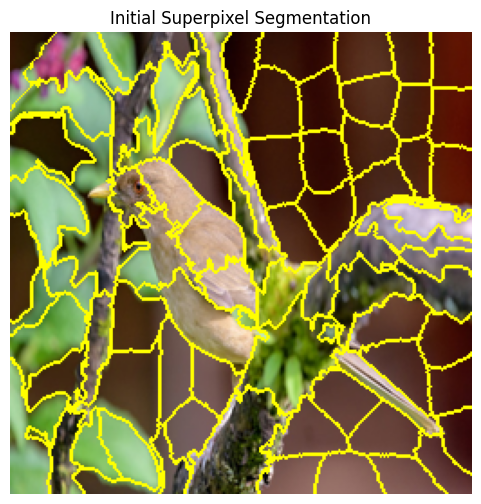

In [9]:
# 이미지 로드
image_path = "bird.jpg"  # 여기에 사용하려는 이미지 경로를 입력하세요
image = load_image(image_path)

# 초기 Superpixel 분할
segments = segment_image(image, n_segments=100)

# 초기 분할 시각화
visualize_initial_segmentation(image, segments)

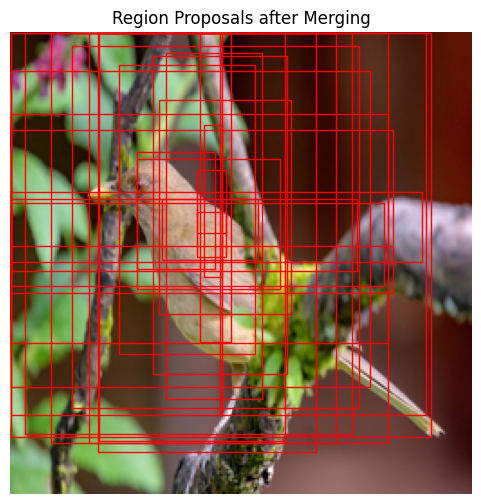

In [10]:
# Region Proposal 생성
region_props = merge_regions(image, segments, num_merges=50)

# Region Proposal 시각화
visualize_proposals(image, region_props)